### Pyportfolioopt 库的上手使用——一起构建第一款基金投资组合

前几天在领英上看到Robert Martin更新了pyportfolioopt v1.4。作为一个集成了常用投资组合模型的函数包，试用了一段时间之后还是觉得非常不错，
正好去年的A股在年中左右牛市了一把，许多人也在那时候通过投资基金获得了自己在资本市场中的第一份收益，其中包括著名的招商白酒指数基金。下面我将尝试以目前市场上近期比较火，收益比较高的基金，同时兼顾尽可能多种类的基金作为投资标的搭建一个Portfolio，**对应结果仅供参考，并不构成投资建议。**

考虑到国内经济复苏持续，优先选取了一些金融、工业、消费板块的基金，同时受最近大宗商品热度的影响选取了几支商品型基金。
同时，我们使用沪深300指数的回报率作为市场回报率。

我们选取的相应投资标的有：

| Name                  | Code | Category |
| --------------------- | ---- | -------- |
| 工银新金融股票        |   001054.OF   | 股票型   |
| 融通行业景气组合      |   161606.OF   | 混合型   |
| 易方达消费行业        |   110022.OF   | 股票型   |
| 易方达消费精选        |    009265.OF  | 股票型   |
| 广发双擎升级混合      |   005911.OF   | 混合型   |
| 万家行业优选混合      |    161903.OF  | 混合型   |
| 广发全球精选股票      |    270023.OF  | QDII     |
| 招商医药股票          |    000960.OF  | 股票型   |
| 中海量化策略混合      |  398041.OF    | 混合型   |
| 华安安信消费混合      |  519002.OF    | 混合型   |
| 大成有色金属期货EFT   |    159980.OF  | ETF      |
| 西部利得稳健双利债券A |   675011.OF   | 债券型   |
| 南方原油LOF           |   501018.OF   | QDII     |
| 银华消费主题混合      |   161818.OF   | 混合型   |
| 招商中证白酒指数 |161725.OF | 股票型 |

这些基金近半年的表现都非常抢眼，简单结合上述基金最近半年的表现，应该如何配置单个基金在自己投资组合中的比例呢？

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from IPython.core.display import display
from pypfopt import risk_models,efficient_frontier,plotting,expected_returns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

tickers = ['000960','001054','005911','009265','110022','159980','161606',
           '161725','161818','161903','270023','398041','501018','519002','675011','000300']

def data_formalization(path):
    df =  pd.read_excel(path,sheet_name='Sheet0',parse_dates=True)
    name = df.iat[1,1]
    df_price = df[['交易时间','净值']]
    df_return = df[['交易时间','涨跌幅%']]
    df_price.set_index('交易时间',inplace=True)
    df_return.set_index('交易时间',inplace=True)
    df_price = df_price.loc['2020-06-01':'2021-02-09']
    df_return = df_return.loc['2020-06-01':'2021-02-09']
    df_price.columns=[name]
    df_return.columns=[name]
    return df_price,df_return,name

df_all_data_price,df_all_data_return,name = data_formalization(path='000960.xlsx')

The Historical Prices


,招商医药健康产业股票,工银新金融股票,广发双擎升级混合A,易方达消费精选股票,易方达消费行业股票,大成有色金属期货ETF,融通行业景气混合A,招商中证白酒指数(LOF),银华消费主题混合,万家行业优选混合(LOF),广发全球精选股票(QDII),中海量化策略混合,南方原油(QDII-FOF-LOF)A,华安安信消费混合,西部利得稳健双利债券A,沪深300
交易时间,,,,,,,,,,,,,,,,
2020-06-01,2.349,1.548,2.6115,1.0294,3.274,0.9220,2.028,1.0987,1.1745,1.5994,1.958,1.333,0.5052,2.615,1.153,3971.340
2020-06-02,2.292,1.537,2.5968,1.0278,3.246,0.9261,1.998,1.0862,1.1655,1.5901,1.965,1.337,0.5193,2.566,1.151,3983.567
2020-06-03,2.311,1.539,2.5945,1.0313,3.234,0.9323,2.023,1.0798,1.1564,1.5912,1.979,1.332,0.5248,2.579,1.150,3983.647
2020-06-04,2.320,1.539,2.5903,1.0430,3.281,0.9299,2.019,1.1006,1.1640,1.5895,1.961,1.325,0.5233,2.583,1.151,3982.185
2020-06-05,2.333,1.543,2.6125,1.0417,3.314,0.9322,2.036,1.1219,1.1641,1.6122,1.981,1.331,0.5498,2.597,1.147,4001.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,3.569,2.920,3.8684,1.4963,5.658,1.1566,3.302,1.4838,2.0934,2.3664,3.909,1.731,0.6477,3.847,1.541,5485.200
2021-02-04,3.514,2.925,3.8616,1.4902,5.642,1.1637,3.257,1.4920,2.0874,2.3626,3.886,1.704,0.6523,3.795,1.519,5473.947
2021-02-05,3.607,2.925,3.8339,1.5029,5.706,1.1723,3.210,1.5084,2.0943,2.2950,3.882,1.712,0.6603,3.746,1.501,5483.414


,招商医药健康产业股票,工银新金融股票,广发双擎升级混合A,易方达消费精选股票,易方达消费行业股票,大成有色金属期货ETF,融通行业景气混合A,招商中证白酒指数(LOF),银华消费主题混合,万家行业优选混合(LOF),广发全球精选股票(QDII),中海量化策略混合,南方原油(QDII-FOF-LOF)A,华安安信消费混合,西部利得稳健双利债券A
交易时间,,,,,,,,,,,,,,,
2020-06-01,0.0168831,0.0285714,0.0257266,0.00753643,0.0224859,0.0100788,0.0257967,0.0313527,0.020594,0.0337384,0.0251309,0.0325329,0.0282924,0.0246865,0.007867
2020-06-02,-0.0242656,-0.00710597,-0.00562892,-0.00155433,-0.00855219,0.00444688,-0.0147929,-0.0113771,-0.007663,-0.00581468,0.00357512,0.0030008,0.0279096,-0.0187381,-0.001735
2020-06-03,0.00828973,0.0013013,-0.000885715,0.00340532,-0.00369688,0.00669469,0.0125125,-0.00589209,-0.007808,0.000691745,0.00712465,-0.00373971,0.0105912,0.00506625,-0.000869
2020-06-04,0.00389434,0,-0.0016188,0.0113449,0.0145331,-0.00257426,-0.00197724,0.0192628,0.006572,-0.0010684,-0.00909551,-0.00525523,-0.00285825,0.00155097,0.000870
2020-06-05,0.00560345,0.00259906,0.00857038,-0.00124638,0.0100579,0.00247341,0.00841999,0.019353,0.000086,0.0142813,0.0101989,0.00452824,0.0506401,0.00542003,-0.003475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,0.00847696,0.0027473,-0.00178046,0.0129298,0.00999639,-0.00797666,0.00548116,-0.00040419,-0.003285,-0.0143696,0.00488427,0.00289687,0.0128225,0.0026062,-0.006447
2021-02-04,-0.0154105,0.00171229,-0.00175788,-0.00407668,-0.00282782,0.00613867,-0.0136281,0.0055263,-0.002866,-0.00160578,-0.00588386,-0.0155979,0.00710203,-0.013517,-0.014276
2021-02-05,0.0264656,0,-0.00717318,0.00852232,0.0113434,0.00739022,-0.0144304,0.0109919,0.003306,-0.0286126,-0.00102932,0.00469485,0.0122643,-0.0129117,-0.011850


<AxesSubplot:xlabel='交易时间'>

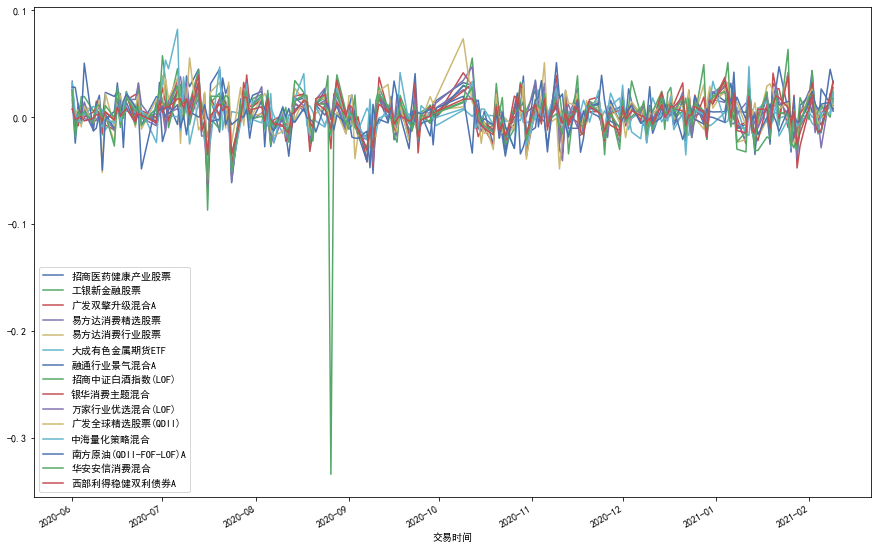

In [352]:
# Now combine all data into one DataFrame
for ticker in tickers[1:]:
    path = ticker+'.xlsx'
    df_price,df_return,name = data_formalization(path)
    df_all_data_return[name] = df_return[name]
    df_all_data_price[name] = df_price[name]

print('The Historical Prices')
display(df_all_data_price)

df_tilde = df_all_data_return.loc[:,:'西部利得稳健双利债券A']
df_tilde.subtract(df_all_data_return['沪深300'], axis = 0)
df_tilde = df_tilde/100
display(df_tilde)
display(df_tilde.plot(figsize = (15,10)))

## Mean-Variance Portfolio - The Tangent Portfolio
Mean-Variance Portfolio could be divided into the Global Minimum Variance (GMV) portfolio
and the portfolio tangent to the MV frontier going through the origin.

* The MV Frontier:
$
\omega^t = (\frac{1}{1'\Sigma^{-1}\mu})\Sigma^{-1}\mu
$
* Where, $\Sigma$ is the **matrix of covariance of asset returns**, then we convert it
* Where, $\mu$ is the N*1 vector of mean returns

In [353]:
df_tilde_annual = 12*df_tilde.fillna(0).resample('M').sum()
mu_tilde = df_tilde_annual.mean()
sigma = df_tilde_annual.std()/np.sqrt(12)
table_statistic = pd.DataFrame({'Mean':mu_tilde, 'Volatility':sigma, 'Sharpe Ratio':mu_tilde/sigma})
table_statistic

,Mean,Volatility,Sharpe Ratio
招商医药健康产业股票,0.670376,0.339889,1.972341
工银新金融股票,0.964691,0.217247,4.440537
广发双擎升级混合A,0.649388,0.264952,2.450966
易方达消费精选股票,0.566381,0.163829,3.457155
易方达消费行业股票,0.839667,0.243192,3.452691
大成有色金属期货ETF,0.364504,0.133566,2.729021
融通行业景气混合A,0.781784,0.235968,3.313090
招商中证白酒指数(LOF),0.645460,0.455806,1.416087
银华消费主题混合,0.857760,0.272582,3.146790
万家行业优选混合(LOF),0.614362,0.192117,3.197860


In [354]:
def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()
    # N is the number of assets
    N = Sigma.shape[0]
    Sigma_adj = Sigma.copy()
    if diagonalize_Sigma:
        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))
    mu_tilde = df_tilde.mean()
    Sigma_inv = np.linalg.inv(Sigma_adj)
    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    omega_tangency = pd.Series(weights, index=mu_tilde.index)
    return omega_tangency, mu_tilde, Sigma

omega_tangency, mu_tilde, Sigma = compute_tangency(df_tilde_annual,diagonalize_Sigma=True)
# use the diagonalized sigma to avoid extreme long-short positions, as you cannot short the fund
display(omega_tangency.apply(lambda x:format(x, '.2%')))

招商医药健康产业股票              3.11%
工银新金融股票                10.95%
广发双擎升级混合A               4.95%
易方达消费精选股票              11.30%
易方达消费行业股票               7.60%
大成有色金属期货ETF            10.94%
融通行业景气混合A               7.52%
招商中证白酒指数(LOF)           1.66%
银华消费主题混合                6.18%
万家行业优选混合(LOF)           8.92%
广发全球精选股票(QDII)          7.19%
中海量化策略混合                3.86%
南方原油(QDII-FOF-LOF)A     2.46%
华安安信消费混合                5.56%
西部利得稳健双利债券A             7.79%
dtype: object

In [355]:
mean = mu_tilde @ omega_tangency
vol = np.sqrt(omega_tangency @ Sigma @ omega_tangency)/np.sqrt(12)
sharpe_ratio = mean/vol
print("Mean: ",mean,", vol: ",vol,", sharpe_ratio: ",sharpe_ratio)

Mean:  0.6724953466661767 , vol:  0.17684387672030652 , sharpe_ratio:  3.8027629745404457


### Targeted M-V Portfolio
基于这样的MV Frontier，如果我们想要取得70%的年化收益率，将Target Return定为0.7，得到符合MV-Optimal，
相应资产的Allocation如下：

招商医药健康产业股票              3.24%
工银新金融股票                11.40%
广发双擎升级混合A               5.16%
易方达消费精选股票              11.76%
易方达消费行业股票               7.92%
大成有色金属期货ETF            11.39%
融通行业景气混合A               7.83%
招商中证白酒指数(LOF)           1.73%
银华消费主题混合                6.44%
万家行业优选混合(LOF)           9.28%
广发全球精选股票(QDII)          7.48%
中海量化策略混合                4.01%
南方原油(QDII-FOF-LOF)A     2.56%
华安安信消费混合                5.79%
西部利得稳健双利债券A             8.10%
dtype: object

Mean:  0.7000000000000002 , vol:  0.1840766844230131 , sharpe_ratio:  3.8027629745404457


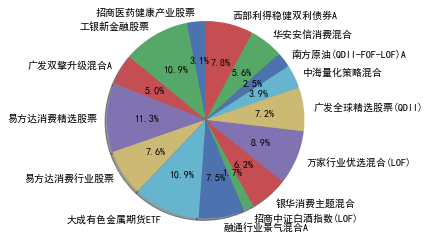

In [356]:
def target_mv_portfolio(df_tilde, target_return=0.06, diagonalize_Sigma=False):

    omega_tangency, mu_tilde, Sigma = compute_tangency(df_tilde, diagonalize_Sigma=diagonalize_Sigma)
    Sigma_adj = Sigma.copy()
    if diagonalize_Sigma:
        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))
    Sigma_inv = np.linalg.inv(Sigma_adj)
    N = Sigma_adj.shape[0]
    delta_tilde = ((np.ones(N) @ Sigma_inv @ mu_tilde)/(mu_tilde @ Sigma_inv @ mu_tilde)) * target_return
    omega_star = delta_tilde * omega_tangency
    return omega_star

omega_star = target_mv_portfolio(df_tilde_annual, target_return=0.7, diagonalize_Sigma=True)
display(omega_star.apply(lambda x:format(x, '.2%')))

#Stats
mean_star = df_tilde_annual.mean() @ omega_star
vol_star = np.sqrt(omega_star @ df_tilde_annual.cov() @ omega_star)/np.sqrt(12)
sharpe_ratio_star = mean/vol
print("Mean: ",mean_star,", vol: ",vol_star,", sharpe_ratio: ",sharpe_ratio_star)

labels = omega_star.index.to_list()
sizes = omega_star.values.tolist()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### GMV Portfolio
下面我们用pyportfolioopt库中的GMV(Global Minimum Variance)模型来重新构建我们的投资组合。

,招商医药健康产业股票,工银新金融股票,广发双擎升级混合A,易方达消费精选股票,易方达消费行业股票,大成有色金属期货ETF,融通行业景气混合A,招商中证白酒指数(LOF),银华消费主题混合,万家行业优选混合(LOF),广发全球精选股票(QDII),中海量化策略混合,南方原油(QDII-FOF-LOF)A,华安安信消费混合,西部利得稳健双利债券A,沪深300
招商医药健康产业股票,0.095714,0.047746,0.063509,0.038249,0.043348,0.005216,0.052012,0.054754,0.047601,0.056631,0.040446,0.023401,0.005456,0.051973,0.039129,0.034752
工银新金融股票,0.047746,0.058019,0.060306,0.033559,0.043965,0.005018,0.054524,0.059966,0.045974,0.052776,0.036271,0.043479,0.005872,0.050880,0.038666,0.043992
广发双擎升级混合A,0.063509,0.060306,0.085008,0.034594,0.042599,0.006292,0.061064,0.061297,0.045934,0.066985,0.041851,0.039026,0.004734,0.056362,0.046280,0.045847
易方达消费精选股票,0.038249,0.033559,0.034594,0.045709,0.044757,0.003137,0.036157,0.053354,0.044470,0.033200,0.040158,0.022031,0.008035,0.035320,0.026954,0.028703
易方达消费行业股票,0.043348,0.043965,0.042599,0.044757,0.064896,0.005372,0.047357,0.083574,0.055172,0.039078,0.033767,0.029644,0.007789,0.044960,0.034905,0.037758
大成有色金属期货ETF,0.005216,0.005018,0.006292,0.003137,0.005372,0.013016,0.003452,0.006994,0.005342,0.004630,0.002148,0.002594,-0.000824,0.004136,0.005077,0.004812
融通行业景气混合A,0.052012,0.054524,0.061064,0.036157,0.047357,0.003452,0.072547,0.057594,0.046272,0.053923,0.040910,0.038476,0.009230,0.053447,0.041931,0.044322
招商中证白酒指数(LOF),0.054754,0.059966,0.061297,0.053354,0.083574,0.006994,0.057594,0.281291,0.070471,0.050448,0.045030,0.041736,0.013692,0.058800,0.046474,0.049705
银华消费主题混合,0.047601,0.045974,0.045934,0.044470,0.055172,0.005342,0.046272,0.070471,0.059569,0.045399,0.042195,0.031913,0.007627,0.047697,0.035694,0.038183
万家行业优选混合(LOF),0.056631,0.052776,0.066985,0.033200,0.039078,0.004630,0.053923,0.050448,0.045399,0.075672,0.042725,0.037011,0.004246,0.051470,0.039138,0.041262


<AxesSubplot:>

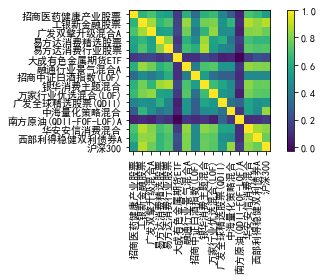

In [357]:
# Calculating the covariance matrix
sample_covr = risk_models.sample_cov(df_all_data_price)
display(sample_covr)
plotting.plot_covariance(sample_covr,plot_correlation=True)


我们可以注意到上图有非常多的Bright Bricks，说明我们所选取的部分标的之间有比较强的相关性。
实际上也确实如此，我们在选取基金标的的时候，
并不是按照fully diversified的思路去做的，而是选取了近期走势比较好的一些基金，而这些基金之间难免会有自身概念和投资标的的重复。

比如我们同时选取了两支消费概念的基金：银华消费主题混合和易方达消费行业股票。
但是在我们在实际操作及运用模型的过程中，并不希望标的之间有过强的covariance，否则最后的结果会出现extreme long/short position.

因此可以改用Ledoit-Wolf Shrinkage来降低extreme values.
同样，在前文中我用了historical mean来作为expected mean，实际上也不是最好的选择，下文会直接通过计算CAPM Mean来作为Expected Mean.

<AxesSubplot:>

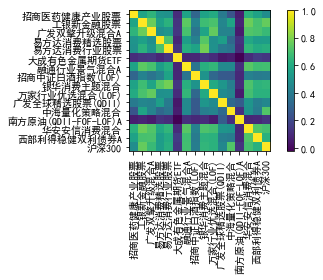

In [358]:
improved_covr = risk_models.CovarianceShrinkage(df_all_data_price).ledoit_wolf()
plotting.plot_covariance(improved_covr,plot_correlation=True)

招商医药健康产业股票             1.092999
工银新金融股票                1.063986
广发双擎升级混合A              1.187664
易方达消费精选股票              0.830014
易方达消费行业股票              1.030151
大成有色金属期货ETF            0.137137
融通行业景气混合A              1.113358
招商中证白酒指数(LOF)          1.606925
银华消费主题混合               1.046359
万家行业优选混合(LOF)          1.084808
广发全球精选股票(QDII)         0.954754
中海量化策略混合               0.843760
南方原油(QDII-FOF-LOF)A    0.294974
华安安信消费混合               1.057203
西部利得稳健双利债券A            0.817705
沪深300                  0.894022
Name: mkt, dtype: float64

<AxesSubplot:>

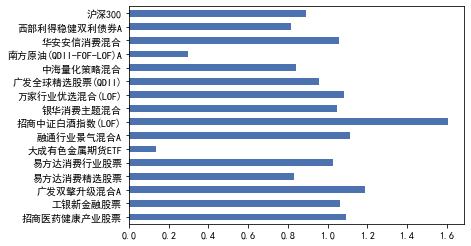

In [359]:
# Mean Calculation - using the CAPM mean
from pypfopt import expected_returns
mu = expected_returns.capm_return(df_all_data_price)
display(mu)
mu.plot.barh()

In [360]:
improved_covr_gmv = risk_models.CovarianceShrinkage(df_all_data_price.loc[:,:'西部利得稳健双利债券A']).ledoit_wolf()
from pypfopt import EfficientFrontier
ef = EfficientFrontier(None, improved_covr_gmv, weight_bounds=(0,1))
ef.min_volatility()
weights_gmv = ef.clean_weights()
weights_gmv

OrderedDict([('招商医药健康产业股票', 0.0),
             ('工银新金融股票', 0.0),
             ('广发双擎升级混合A', 0.0),
             ('易方达消费精选股票', 0.10849),
             ('易方达消费行业股票', 0.0),
             ('大成有色金属期货ETF', 0.55462),
             ('融通行业景气混合A', 0.0),
             ('招商中证白酒指数(LOF)', 0.0),
             ('银华消费主题混合', 0.0),
             ('万家行业优选混合(LOF)', 0.0),
             ('广发全球精选股票(QDII)', 0.0),
             ('中海量化策略混合', 0.05958),
             ('南方原油(QDII-FOF-LOF)A', 0.16509),
             ('华安安信消费混合', 0.0),
             ('西部利得稳健双利债券A', 0.11222)])

Mean:  0.41503754478941574 , vol:  0.10898582999276914 , sharpe_ratio:  3.808178960668118


<AxesSubplot:>

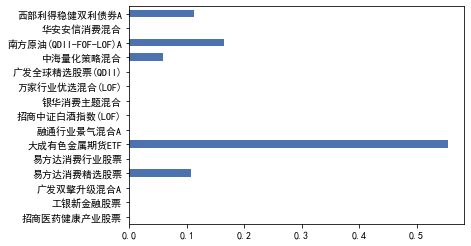

In [361]:
weights_gmv = pd.Series(weights_gmv)
mean_gmv = df_tilde_annual.mean() @ weights_gmv
vol_gmv = ef.portfolio_performance()[1]
sharpe_gmv = mean_gmv/vol_gmv
sharpe_gmv
print("Mean: ",mean_gmv,", vol: ",vol_gmv,", sharpe_ratio: ",sharpe_gmv)
pd.Series(weights_gmv).plot.barh()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:ylabel='None'>

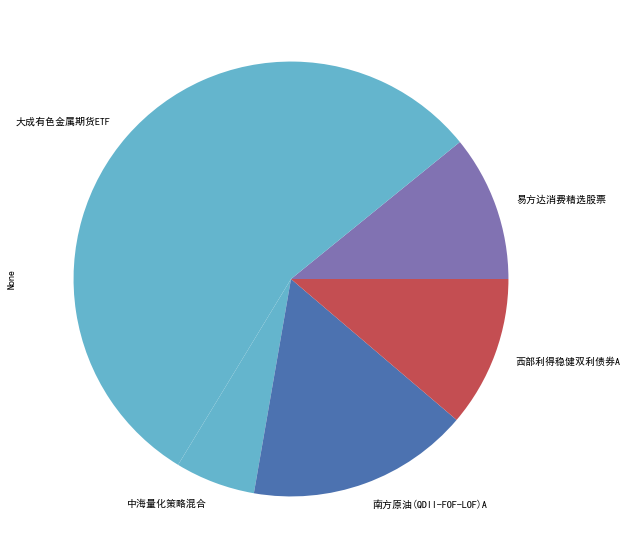

In [362]:
pd.Series(weights_gmv).plot.pie(figsize = (10,10))

我们注意到在上面利用GMV给出的模型里面，大成有色金属期货EFT被分配到了一半以上的配置，而大宗商品ETF本身不稳定，我们所选取的数据区间并不足以体现所有的波动，
因此我们可能考虑需要对不同类型的基金设定一个cap，即投资占比上限，之后重新计算各个基金的配比。

In [363]:
mu = expected_returns.capm_return(df_all_data_price.loc[:,:'西部利得稳健双利债券A'])
Sigma = risk_models.CovarianceShrinkage(df_all_data_price.loc[:,:'西部利得稳健双利债券A']).ledoit_wolf()
ef_capped = EfficientFrontier(mu,Sigma)

category_mapper = {'招商医药健康产业股票':'Stock-Based', '工银新金融股票':'Stock-Based', '广发双擎升级混合A':'Hybrid', '易方达消费精选股票':'Stock-Based',
                 '易方达消费行业股票':'Stock-Based', '大成有色金属期货ETF':'Commodity-Based', '融通行业景气混合A':'Hybrid', '招商中证白酒指数(LOF)':'Stock-Based',
                 '银华消费主题混合':'Hybrid', '万家行业优选混合(LOF)':'Hybrid', '广发全球精选股票(QDII)':'Stock-Based',
                 '中海量化策略混合':'Hybrid', '南方原油(QDII-FOF-LOF)A':'Commodity-Based', '华安安信消费混合':'Hybrid', '西部利得稳健双利债券A':'Bond-Based'}
lower_bound = {'Bond-Based':0.1} # for risk control, we want at least 10% of our portfolio is bond-based fund
upper_bound = {'Stock-Based':0.4,'Commodity-Based':0.2}

ef_capped.add_sector_constraints(category_mapper,lower_bound,upper_bound)
ef_capped.max_sharpe()
weight_capped = ef_capped.clean_weights()
weight_capped = pd.Series(weight_capped)
display(weight_capped)

# Stats
mean_capped = df_tilde_annual.mean() @ weight_capped
vol_capped = ef_capped.portfolio_performance()[1]
sharpe_capped = mean_capped/vol_capped
print("Mean: ",mean_capped,", vol: ",vol_capped,", sharpe_ratio: ",sharpe_capped)

招商医药健康产业股票             0.06782
工银新金融股票                0.06457
广发双擎升级混合A              0.06733
易方达消费精选股票              0.05978
易方达消费行业股票              0.06676
大成有色金属期货ETF            0.03730
融通行业景气混合A              0.06635
招商中证白酒指数(LOF)          0.07068
银华消费主题混合               0.07143
万家行业优选混合(LOF)          0.06748
广发全球精选股票(QDII)         0.07040
中海量化策略混合               0.06685
南方原油(QDII-FOF-LOF)A    0.06039
华安安信消费混合               0.06288
西部利得稳健双利债券A            0.10000
dtype: float64

Mean:  0.6654015122199907 , vol:  0.19022399698042275 , sharpe_ratio:  3.497989332484017


<AxesSubplot:ylabel='None'>

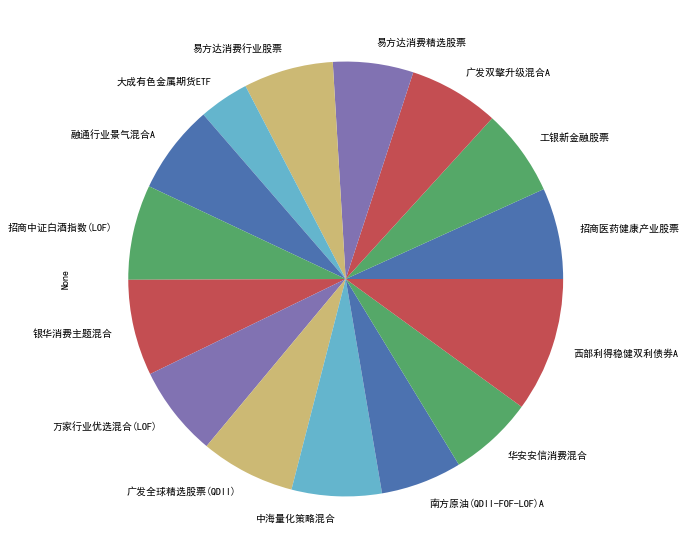

In [364]:
pd.Series(weight_capped).plot.pie(figsize = (10,10))


### Risk Management's Portfolios - VaR and CVaR
In this section we will compute both the VaR and the CVaR of the fund performances, and build up our portfolios accordingly.

<AxesSubplot:>

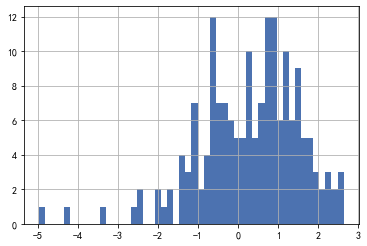

In [365]:
portfolio_rets = (df_all_data_return*weight_capped).sum(axis=1)
portfolio_rets.hist(bins = 50)

In [366]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print('VaR:{:.2f}%'.format((var)))
print('CVaR:{:.2f}%'.format(cvar))

VaR:-1.71%
CVaR:-2.85%


In [367]:
# to construct a portfolio with the minimum CVaR
from pypfopt import EfficientCVaR
ec = EfficientCVaR(mu,df_all_data_return.loc[:,:'西部利得稳健双利债券A']/100)
ec.min_cvar()
min_cvar_wghs = pd.Series(ec.clean_weights())
display(min_cvar_wghs)
ec.portfolio_performance(verbose=True)


招商医药健康产业股票             0.01444
工银新金融股票                0.00000
广发双擎升级混合A              0.00000
易方达消费精选股票              0.00000
易方达消费行业股票              0.00000
大成有色金属期货ETF            0.75703
融通行业景气混合A              0.00000
招商中证白酒指数(LOF)          0.00000
银华消费主题混合               0.00000
万家行业优选混合(LOF)          0.00000
广发全球精选股票(QDII)         0.00000
中海量化策略混合               0.00000
南方原油(QDII-FOF-LOF)A    0.22854
华安安信消费混合               0.00000
西部利得稳健双利债券A            0.00000
dtype: float64

Expected annual return: 19.0%
Conditional Value at Risk: 1.21%


(0.19026629496931582, 0.012086125616393622)

In [368]:
# Now to move a step further to upgrade our target CVaR to 2%, in order to have higher returns
ec_ = EfficientCVaR(mu,df_all_data_return.loc[:,:'西部利得稳健双利债券A']/100)
ec_.efficient_risk(target_cvar=0.02)
target_cvar_wghs = pd.Series(ec_.clean_weights())
display(target_cvar_wghs)
ec_.portfolio_performance(verbose=True)

招商医药健康产业股票             0.00000
工银新金融股票                0.24304
广发双擎升级混合A              0.00000
易方达消费精选股票              0.00000
易方达消费行业股票              0.04322
大成有色金属期货ETF            0.23601
融通行业景气混合A              0.00000
招商中证白酒指数(LOF)          0.01892
银华消费主题混合               0.00000
万家行业优选混合(LOF)          0.00000
广发全球精选股票(QDII)         0.26090
中海量化策略混合               0.00210
南方原油(QDII-FOF-LOF)A    0.04189
华安安信消费混合               0.00000
西部利得稳健双利债券A            0.15392
dtype: float64

Expected annual return: 76.6%
Conditional Value at Risk: 2.00%


(0.7664289454501447, 0.020000000001294815)

### 简单对上面几种配置方法得到的资产权重以及对应的指标做个总结

In [369]:
omega_tangency.rename('Tangent Portfolio', inplace=True)
omega_star.rename('70% Returns MV Portfolio', inplace = True)
weights_gmv.rename('GMV Portfolio',inplace = True)
weight_capped.rename('Capped Portfolio',inplace = True)
min_cvar_wghs.rename('Min CVaR Portfolio',inplace = True)
target_cvar_wghs.rename('2% Target CVaR Portfolio',inplace = True)
summary = pd.concat([omega_tangency,omega_star,weights_gmv,weight_capped,min_cvar_wghs,target_cvar_wghs],axis=1)
display(summary)
portfolio_names = summary.columns.to_list()
stats_indicators = pd.DataFrame({'Strategies':portfolio_names,'Mean Returns':['67.25%','70%','41.5%','66.54%','19.03%','76.64%'],
                                 'Volatility/CVaR':['0.1768','0.1841','0.1090','0.1902','0.0121','0.0200']})
display(stats_indicators)

,Tangent Portfolio,70% Returns MV Portfolio,GMV Portfolio,Capped Portfolio,Min CVaR Portfolio,2% Target CVaR Portfolio
招商医药健康产业股票,0.031081,0.032353,0.00000,0.06782,0.01444,0.00000
工银新金融股票,0.109480,0.113958,0.00000,0.06457,0.00000,0.24304
广发双擎升级混合A,0.049548,0.051574,0.00000,0.06733,0.00000,0.00000
易方达消费精选股票,0.113027,0.117650,0.10849,0.05978,0.00000,0.00000
易方达消费行业股票,0.076044,0.079154,0.00000,0.06676,0.00000,0.04322
大成有色金属期货ETF,0.109437,0.113913,0.55462,0.03730,0.75703,0.23601
融通行业景气混合A,0.075203,0.078278,0.00000,0.06635,0.00000,0.00000
招商中证白酒指数(LOF),0.016640,0.017321,0.00000,0.07068,0.00000,0.01892
银华消费主题混合,0.061833,0.064362,0.00000,0.07143,0.00000,0.00000
万家行业优选混合(LOF),0.089156,0.092802,0.00000,0.06748,0.00000,0.00000


,Strategies,Mean Returns,Volatility/CVaR
0,Tangent Portfolio,67.25%,0.1768
1,70% Returns MV Portfolio,70%,0.1841
2,GMV Portfolio,41.5%,0.1090
3,Capped Portfolio,66.54%,0.1902
4,Min CVaR Portfolio,19.03%,0.0121
5,2% Target CVaR Portfolio,76.64%,0.0200


### Appendix - Plotting the Efficient Frontier
Unconstrained and Complex Plotting

In [370]:
from pypfopt import CLA, plotting
cla = CLA(mu,Sigma)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)

Expected annual return: 95.1%
Annual volatility: 18.3%
Sharpe Ratio: 5.08


(0.9505451062978508, 0.18326653912397028, 5.077550494192425)

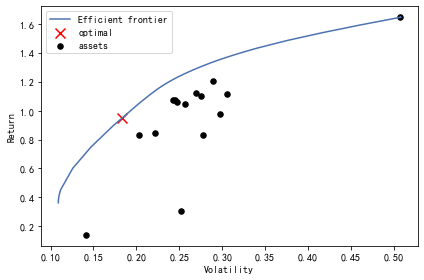

In [371]:
plot_ef = plotting.plot_efficient_frontier(cla,showfig = False)


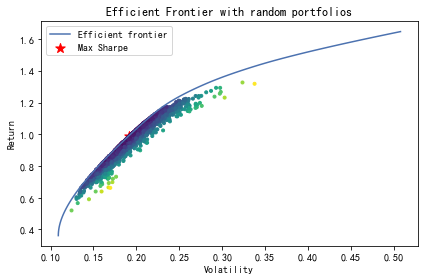

In [372]:
## Plotting the Efficient Frontier and Simulated Portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)),n_samples)
returns = w.dot(mu)
stds = np.sqrt((w.T * (Sigma @ w.T)).sum(axis=0))
sharpes = returns/stds

ef_random = EfficientFrontier(mu,Sigma)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_random, ax=ax,show_assets = False)

# Tangency Portfolio
ef_random.max_sharpe()
ret_tangent, std_tangent, _ = ef_random.portfolio_performance()
ax.scatter(std_tangent,ret_tangent,marker = "*", s=100,c="r",label = 'Max Sharpe')

# All other Random Portfolios
ax.scatter(stds,returns,marker = ".", c=sharpes,cmap='viridis_r')

# Format
ax.set_title('Efficient Frontier with random portfolios')
ax.legend()
plt.tight_layout()
plt.show()